In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import Lasso, LassoCV
import scipy.stats as stats
import statsmodels.stats.api as sms

In [23]:
# load data
os.chdir('C:/Users/Mayin\Documents/1GRADUATE/1. Study/2. 24Spring/5291 Aadvanced Statistical Analysis/5291 Project/')
x_train = pd.read_csv('x_train_scale.csv').drop(['test_time', 'subject#'], axis=1)
y_train = pd.read_csv('y_train_scale.csv')
x_test = pd.read_csv('x_test_scale.csv').drop(['test_time', 'subject#'], axis=1)
y_test = pd.read_csv('y_test_scale.csv')

In [24]:
# data summary
x_train.head()
y_train.head()
# x_train.describe()

,total_UPDRS,motor_UPDRS
0,0.931864,0.809740
1,-0.330508,-0.561949
2,0.317205,0.019912
3,-1.021484,-1.129467
4,-0.257937,-0.492215


In [25]:
# 2 responses
y_t_train = y_train['total_UPDRS']
y_t_test = y_test['total_UPDRS']
y_m_train = y_train['motor_UPDRS']
y_m_test = y_test['motor_UPDRS']

## total_UPDRS

### 1. lambda vs coefficients

In [ ]:
# candidate lambdas
Lambdas = np.logspace(-5, 2, 200)

# store coeddicients
lasso_cofficients = []
for Lambda in Lambdas:
    lasso = Lasso(alpha=Lambda, normalize=True, max_iter=10000)
    lasso.fit(x_train, y_t_train)
    lasso_cofficients.append(lasso.coef_)

# 不用管这些warining，return在另外的cell里报

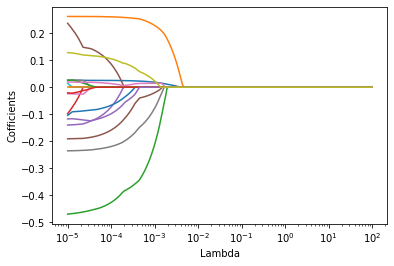

In [26]:
# Plot lambda
plt.plot(Lambdas, lasso_cofficients)

# log x-axis
plt.xscale('log')

plt.xlabel('Lambda')
plt.ylabel('Cofficients')
plt.show()

Result: with the increasement of lambda, all the coefficients shink to 0.

### 2. 10-fold to fix the best lambda

In [ ]:
# Cross Validation: 10-fold
lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(x_train, y_t_train)

# 不用管warning，return在另外的cell里报，下同

In [43]:
# best lambda
lasso_best_alpha = lasso_cv.alpha_  
print("best_lambda:", lasso_best_alpha)

best_lambda: 2.643081486974103e-05


Therefore, the best lambda for this model is:
best_lambda: 2.643081486974103e-05

### 3. fit LASSO with best lambda obtained before

In [ ]:
# LASSO modeling with best lambda
lasso = Lasso(alpha=lasso_best_alpha, normalize=True, max_iter=10000)
lasso.fit(x_train, y_t_train)

In [44]:
# return coefficients
lasso_coeff = pd.Series(index=['Intercept'] + x_train.columns.tolist(), data=[lasso.intercept_] + lasso.coef_.tolist())
# sort the coefficients from highest absolute value to lowest
df = pd.DataFrame({
    'original_coeff': lasso_coeff,
    'abs_coeff': lasso_coeff.abs()
})

sorted_lasso_coeff = df.sort_values(by='abs_coeff', ascending=False)['original_coeff']

print(sorted_lasso_coeff)
# 按照绝对值从打到小排列，越靠前越重要

sex             -0.261555
age              0.248927
HNR             -0.228892
DFA             -0.197350
Jitter(Abs)     -0.181991
PPE              0.146573
Jitter:RAP       0.126089
Shimmer:APQ3    -0.118474
Shimmer:APQ11    0.103366
Intercept        0.081972
Shimmer:APQ5    -0.081825
NHR             -0.069613
RPDE             0.051717
Jitter:DDP       0.025717
Jitter:PPQ5     -0.023725
Shimmer:DDA     -0.012281
Shimmer          0.000000
Jitter(%)        0.000000
Shimmer(dB)     -0.000000
Name: original_coeff, dtype: float64


<AxesSubplot:>

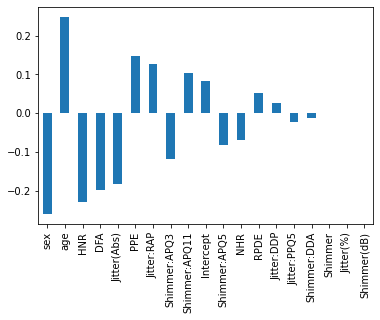

In [36]:
# plot importance
sorted_lasso_coeff.plot(kind='bar')

### 4. Prediction & Evaluation

In [37]:
# prediction & evaluation
y_t_pred_test = lasso.predict(x_test)
y_t_pred_train = lasso.predict(x_train)

print('LASSO R2(train):', lasso.score(x_train, y_t_train))
print('LASSO train MSE:', np.mean((y_t_pred_train - y_t_train) ** 2))
print('LASSO test MSE:', np.mean((y_t_pred_test - y_t_test) ** 2))

LASSO R2(train): 0.17034668596042402
LASSO train MSE: 0.829653314039576
LASSO test MSE: 0.8563017271134965


### 5. Model Test
- QQ-Plot (看上去还可以)
- Breusch-Pagan test （实际上很糟糕）

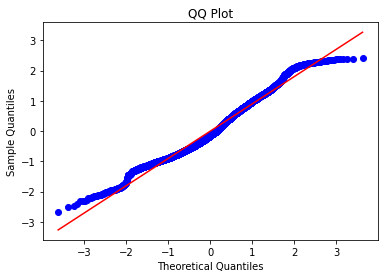

In [38]:
#  QQ plot
residuals = y_t_train - y_t_pred_train
stats.probplot(residuals, dist="norm", plot=plt)

plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [39]:
bp_test = sms.het_breuschpagan(residuals, x_train)

lm, lm_pvalue, fvalue, f_pvalue = bp_test

print(f'LM statistic: {lm}')
print(f'LM-test p-value: {lm_pvalue}')
print(f'F statistic: {fvalue}')
print(f'F-test p-value: {f_pvalue}')

LM statistic: 443.91283609653976
LM-test p-value: 1.1755055013715633e-83
F statistic: 27.12976886677657
F-test p-value: 2.0178396442658547e-87


result : model has heteroskedasticity
### 6. Plot
- Train
- Test

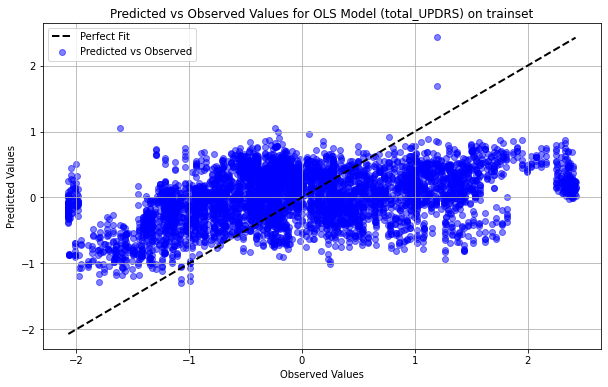

In [40]:
# plot train
y_pred = y_t_pred_train
y_actual = y_t_train
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (total_UPDRS) on trainset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


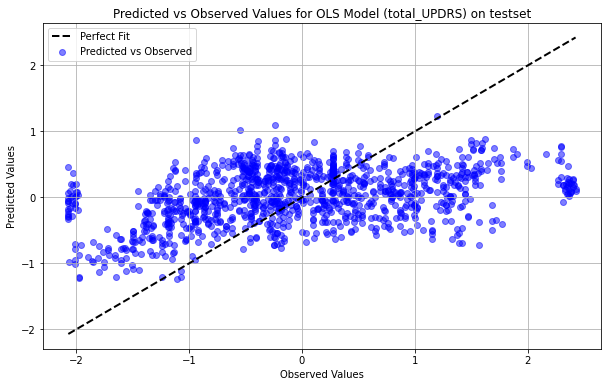

In [41]:
# plot test
y_pred = y_t_pred_test
y_actual = y_t_test
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (total_UPDRS) on testset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## motor_UPDRS

### 1. lambda vs coefficients

In [45]:
# candidate lambdas
Lambdas = np.logspace(-5, 2, 200)

# store coeddicients
lasso_cofficients = []
for Lambda in Lambdas:
    lasso = Lasso(alpha=Lambda, normalize=True, max_iter=10000)
    lasso.fit(x_train, y_m_train)
    lasso_cofficients.append(lasso.coef_)

c:\Users\Mayin\Downloads\python\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Mayin\Downloads\python\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previou

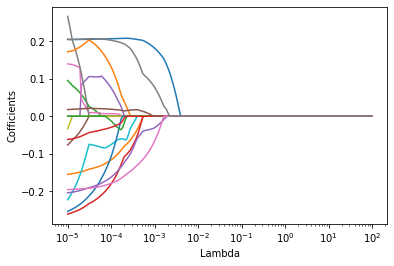

In [46]:
# Plot lambda
plt.plot(Lambdas, lasso_cofficients)

# log x-axis
plt.xscale('log')

plt.xlabel('Lambda')
plt.ylabel('Cofficients')
plt.show()

### 2. 10-fold to fix the best lambda

In [50]:
# Cross Validation: 10-fold
lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(x_train, y_m_train)

c:\Users\Mayin\Downloads\python\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(alphas=array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149e-05, 2.86606762e-05, 3.10786619e-05, 3.37006433e-05,
       3.65438307e-05, 3.96268864e-05, 4.29700470e-05, 4.65952567e-05,
       5.05263107e-05, 5.47890118e-0...
       1.55222536e+01, 1.68318035e+01, 1.82518349e+01, 1.97916687e+01,
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
        cv=10, max_iter=10000, normalize=True)

In [56]:
# best lambda
lasso_best_alpha = lasso_cv.alpha_  
print("best lambda:", lasso_best_alpha)

best lambda: 5.478901179593945e-05


### 3. fit LASSO with best lambda obtained before

In [57]:
# LASSO modeling with best lambda
lasso = Lasso(alpha=lasso_best_alpha, normalize=True, max_iter=10000)
lasso.fit(x_train, y_m_train)

c:\Users\Mayin\Downloads\python\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=5.478901179593945e-05, max_iter=10000, normalize=True)

In [58]:
# return coefficients
lasso_coeff = pd.Series(index=['Intercept'] + x_train.columns.tolist(), data=[lasso.intercept_] + lasso.coef_.tolist())
df = pd.DataFrame({
    'original_coeff': lasso_coeff,
    'abs_coeff': lasso_coeff.abs()
})

sorted_lasso_coeff = df.sort_values(by='abs_coeff', ascending=False)['original_coeff']

print(sorted_lasso_coeff)
# 按照绝对值从打到小排列，越靠前越重要

Jitter(Abs)     -0.213862
PPE              0.206032
age              0.205230
DFA             -0.187156
HNR             -0.180087
Shimmer:APQ11    0.178497
Shimmer:APQ5    -0.173738
sex             -0.132810
Jitter:RAP       0.104729
Shimmer:APQ3    -0.081434
Intercept        0.041623
NHR             -0.037392
RPDE             0.020218
Jitter:DDP       0.009250
Jitter(%)        0.004416
Shimmer          0.000000
Shimmer:DDA     -0.000000
Jitter:PPQ5     -0.000000
Shimmer(dB)     -0.000000
Name: original_coeff, dtype: float64


<AxesSubplot:>

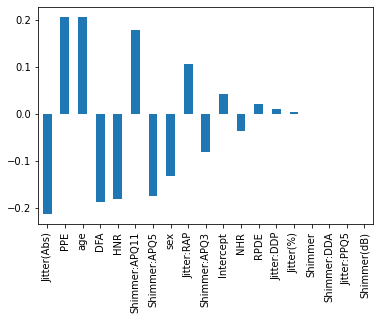

In [60]:
# plot importance
sorted_lasso_coeff.plot(kind='bar')

### 4. Prediction & Evaluation

In [61]:
# prediction & evaluation
y_m_pred_test = lasso.predict(x_test)
y_m_pred_train = lasso.predict(x_train)

print('LASSO R2(train):', lasso.score(x_train, y_m_train))
print('LASSO train MSE:', np.mean((y_m_pred_train - y_m_train) ** 2))
print('LASSO test MSE:', np.mean((y_m_pred_test - y_m_test) ** 2))

LASSO R2(train): 0.1458243369861285
LASSO train MSE: 0.8541756630138718
LASSO test MSE: 0.8879581471430505


### 5. Model Test
- QQ-Plot (看上去还可以)
- Breusch-Pagan test （实际上很糟糕）

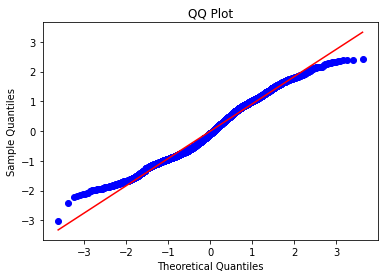

In [62]:
#  QQ plot
residuals = y_m_train - y_m_pred_train
stats.probplot(residuals, dist="norm", plot=plt)

plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [63]:
# Breusch pagan test
bp_test = sms.het_breuschpagan(residuals, x_train)

lm, lm_pvalue, fvalue, f_pvalue = bp_test

print(f'LM statistic: {lm}')
print(f'LM-test p-value: {lm_pvalue}')
print(f'F statistic: {fvalue}')
print(f'F-test p-value: {f_pvalue}')

LM statistic: 828.7034031245518
LM-test p-value: 3.4700060226222487e-165
F statistic: 55.68030182504284
F-test p-value: 1.332285793845988e-181


### 6. Plot
- Train
- Test

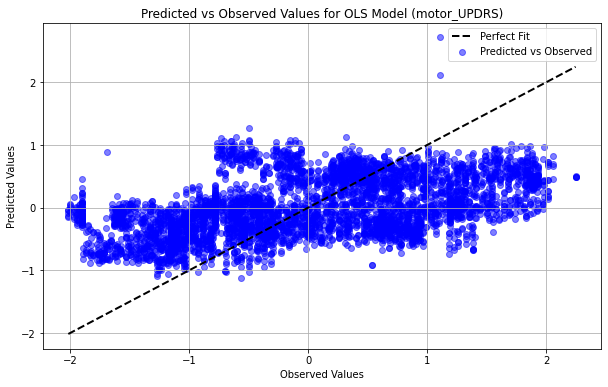

In [98]:
# plot train
y_pred = y_m_pred_train
y_actual = y_m_train
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (motor_UPDRS) on trainset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

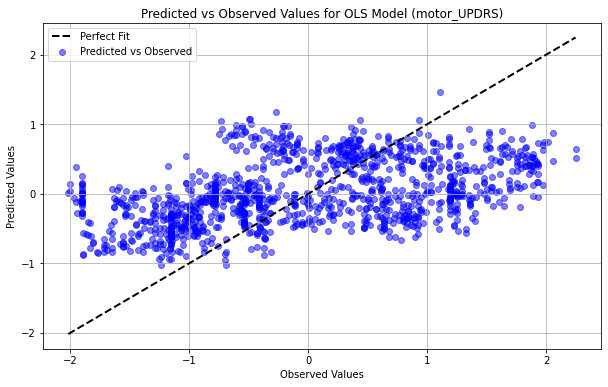

In [100]:
# plot test
y_pred = y_m_pred_test
y_actual = y_m_test
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')  # Plotting the points

# Plot the line of perfect prediction
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Fit')  # Line from min to max of observed

# Labeling the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for OLS Model (motor_UPDRS) on testset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
